Spotipy:lightweight Python library for Spotify Web API.

In [6]:
#!pip install spotipy
#!pip install pandas
#!pip install matplotlib

In [64]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import spotipy # python library for spotify web API
from spotipy.oauth2 import SpotifyClientCredentials
from datetime import datetime, timedelta
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
import requests
#import plotly.express as px
from PIL import Image
import numpy as np
import os

### key for access to Spotify API

In [10]:
my_id = "31628b5b3b6d4f57a64a0ab9755c9ceb"
my_secret = "c8c9611ef1154ebe898dd20033e59203"
client_credentials_manager = SpotifyClientCredentials(client_id=my_id, client_secret=my_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

## Analyzing my spotify data
goal: find trends from my listening history

In [11]:
#requested & downloaded spotify data
df1 = pd.read_json('./StreamingHistory_music_0.json')
df0 = pd.read_json('./StreamingHistory_music_1.json')

In [12]:
df = pd.concat([df1, df0], axis=0,ignore_index = True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17876 entries, 0 to 17875
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   endTime     17876 non-null  object
 1   artistName  17876 non-null  object
 2   trackName   17876 non-null  object
 3   msPlayed    17876 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 558.8+ KB


In [14]:
df.head()

,endTime,artistName,trackName,msPlayed
0,2023-01-28 21:09,NCT DREAM,We Go Up,4864
1,2023-01-28 21:12,NCT DREAM,We Go Up,183293
2,2023-01-28 21:15,NCT DREAM,"1, 2, 3",164332
3,2023-01-28 21:18,NCT DREAM,We Go Up,183293
4,2023-01-28 21:19,NCT DREAM,"1, 2, 3",47838


**How much time do I spend on Spotify?**

In [15]:
df['endTime'] = pd.to_datetime(df['endTime'])
df['endTime'].head()

0   2023-01-28 21:09:00
1   2023-01-28 21:12:00
2   2023-01-28 21:15:00
3   2023-01-28 21:18:00
4   2023-01-28 21:19:00
Name: endTime, dtype: datetime64[ns]

In [16]:
# extract only the date
df['date'] = df['endTime'].dt.floor('D') #D for date, H for hour
df['date'].head()

0   2023-01-28
1   2023-01-28
2   2023-01-28
3   2023-01-28
4   2023-01-28
Name: date, dtype: datetime64[ns]

In [17]:
# get duration converted to minutes
df['minutes'] = df['msPlayed']/1000/60
df['minutes'].head()

0    0.081067
1    3.054883
2    2.738867
3    3.054883
4    0.797300
Name: minutes, dtype: float64

In [18]:
df.head()

,endTime,artistName,trackName,msPlayed,date,minutes
0,2023-01-28 21:09:00,NCT DREAM,We Go Up,4864,2023-01-28,0.081067
1,2023-01-28 21:12:00,NCT DREAM,We Go Up,183293,2023-01-28,3.054883
2,2023-01-28 21:15:00,NCT DREAM,"1, 2, 3",164332,2023-01-28,2.738867
3,2023-01-28 21:18:00,NCT DREAM,We Go Up,183293,2023-01-28,3.054883
4,2023-01-28 21:19:00,NCT DREAM,"1, 2, 3",47838,2023-01-28,0.797300


In [19]:
# get streaming hours per week

# groupby(), Grouper
# very useful function in data analysis
# split obj, apply function, combine results
# Grouper key needs to be datetime, not obj

# agg(): calculate weekly streaming hours
# gets parameters in dict form, use for mulitple features
# reset.index(): for adding simple index (0,1,..)

#still in minutes
stream_hours = df.groupby(pd.Grouper(key='date',freq = 'W-MON')).agg(hours=('minutes','sum')).reset_index()

#convert to hours
stream_hours['hours'] /= 60


stream_hours.head()

,date,hours
0,2023-01-30,6.403742
1,2023-02-06,21.020905
2,2023-02-13,23.127255
3,2023-02-20,18.706324
4,2023-02-27,20.572718


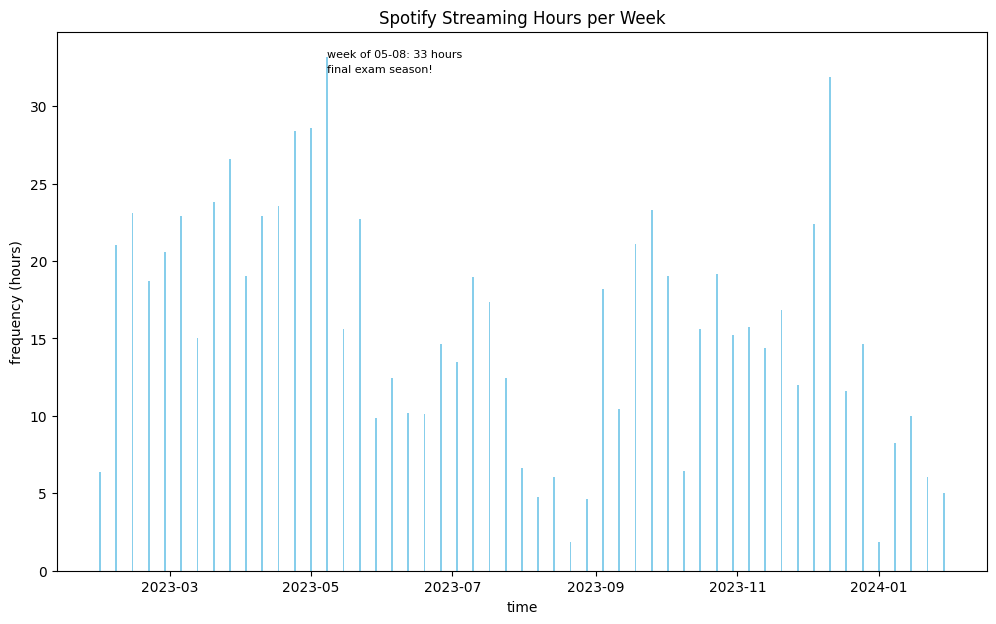

In [21]:
#set figure and axis
fig, ax= plt.subplots(figsize= (12,7),)

#draw bar
bar = ax.bar(stream_hours['date'], stream_hours['hours'], color = 'skyblue')

'''
we can also format the ticks by:
# set_major_formatter(): format x ticks
'''

# labels
ax.set_xlabel('time')
ax.set_ylabel('frequency (hours)')
ax.set_title('Spotify Streaming Hours per Week')

# longest bar length
max_hour_index = stream_hours['hours'].idxmax() # index of max hour
max_hour_x = stream_hours['date'][max_hour_index]
max_hour_y = stream_hours['hours'][max_hour_index]

# comment
ax.annotate(f"week of {max_hour_x.strftime('%m-%d')}: {round(max_hour_y)} hours",(max_hour_x, max_hour_y), fontsize = 8)
ax.annotate('final exam season!', (max_hour_x, max_hour_y-1), fontsize = 8)


plt.show()

Next Q: Which songs did I listen to the most?
---
1. All time
2. During winter break
3. During finals season


## All time

In [22]:
df.head()

,endTime,artistName,trackName,msPlayed,date,minutes
0,2023-01-28 21:09:00,NCT DREAM,We Go Up,4864,2023-01-28,0.081067
1,2023-01-28 21:12:00,NCT DREAM,We Go Up,183293,2023-01-28,3.054883
2,2023-01-28 21:15:00,NCT DREAM,"1, 2, 3",164332,2023-01-28,2.738867
3,2023-01-28 21:18:00,NCT DREAM,We Go Up,183293,2023-01-28,3.054883
4,2023-01-28 21:19:00,NCT DREAM,"1, 2, 3",47838,2023-01-28,0.797300


In [23]:
df_agg_time = df.groupby(['artistName','trackName'], as_index=False).agg(minutes=('minutes','sum'))
df_agg_size = df.groupby(['artistName','trackName'], as_index=False).size()

df_all_stream = pd.merge(df_agg_time, df_agg_size, on=['artistName', 'trackName'], how='outer')
df_all_stream = df_all_stream.sort_values('size',ascending = False).reset_index(drop=True)
df_all_stream

,artistName,trackName,minutes,size
0,BIG Naughty,Vancouver 2,762.507233,237
1,WOODZ,ABYSS,521.568933,163
2,Jung Kook,My You,334.221450,150
3,NCT DREAM,Broken Melodies,447.893233,133
4,FIFTY FIFTY,Barbie Dreams (feat. Kaliii) [From Barbie The ...,303.900467,130
...,...,...,...,...
2708,PARK JI WON (fromis_9),Talk to Me,3.906217,1
2709,Frédéric Chopin,"Chopin: Nocturne No. 20 in C-Sharp Minor, Op. ...",4.360667,1
2710,Frédéric Chopin,"Chopin: Nocturne No. 20 in C-Sharp Minor, Op. ...",4.324883,1
2711,Ourealgoat,Trouble (Feat. Ahn Byeong Woong),2.965517,1


## During winter break

In [26]:
# create dict with trackName: number of times played
winter_start = datetime(2023, 12, 22)
winter_end = datetime(2024, 1, 20)

#only get rows with the endtime between winterbreak
df_winter = df[(df["endTime"] > winter_start) & (df["endTime"] < winter_end)]

df_winter_stream = df_winter.groupby(['artistName','trackName'], as_index=False).size().sort_values('size',ascending = False)
df_winter_stream

,artistName,trackName,size
12,Ahn Eun-jin,With My Heart,11
196,MIYEON,The Painted On The Moonlight,10
294,YeonWoo,Road to You,10
109,Huh Jee,Good Life,9
292,YANG YO SEOP,Unforgettable Love,9
...,...,...,...
136,Isaac Hong,Friends Again,1
137,Isaac Hong,Heartfall,1
140,Isaac Hong,Like A Star,1
141,Isaac Hong,Little Lights,1


## During Final Exams

In [27]:
# create dict with trackName: number of times played
finals_sem2_start = datetime(2023, 12, 13)
finals_sem2_end = datetime(2023, 12, 21)
finals_sem1_start = datetime(2023, 5, 4)
finals_sem1_end = datetime(2023, 5, 11)

finals_stream_dict = {}

#only get rows with the endtime between winterbreak
df_finals = df[((df["endTime"] > finals_sem1_start) & (df["endTime"] < finals_sem1_end)) | ((df["endTime"] > finals_sem2_start) & (df["endTime"] < finals_sem2_end))]

df_finals_stream = df_finals.groupby(['artistName','trackName'], as_index=False).size().sort_values('size',ascending = False)
df_finals_stream.head()

,artistName,trackName,size
15,B.I,COSMOS,106
149,Huh Jee,Sunshine,68
139,Huh Jee,Doing Fine,27
152,Huh Jee,in my head,21
104,Epik High,Fly,20


## Visualize my personal spotify wrapped

goal: I want to get the corresponding album name & image for my top tracks 

## All time

#### What are songs I've listened to more than 25 times?

#### What are my top 25 songs?

In [37]:
df_all_stream_25 = df_all_stream.sort_values(by=['size'], ascending=False)[:25].copy()
df_all_stream_25

,artistName,trackName,minutes,size
0,BIG Naughty,Vancouver 2,762.507233,237
1,WOODZ,ABYSS,521.568933,163
2,Jung Kook,My You,334.221450,150
3,NCT DREAM,Broken Melodies,447.893233,133
4,FIFTY FIFTY,Barbie Dreams (feat. Kaliii) [From Barbie The ...,303.900467,130
5,NewJeans,New Jeans,204.221417,126
6,Epik High,New Beautiful,324.877583,125
7,B.I,COSMOS,401.221983,121
8,NewJeans,Super Shy,277.819267,119
9,Quinn XCII,Look How Far We've Come,325.679583,117


### This is where we call the spotify api!
grab image for all top 25 tracks

In [47]:
#get corresponding images for all tracks
def getAlbumImage(dataframe,filename):
    
    #create folder to save album image
    os.makedirs(f'./{filename}')

    for _, track_info in dataframe.iterrows():
        track_artist = track_info['artistName']
        track_name = track_info['trackName']
        track_occ = track_info['size']
        track_search = sp.search(f"track: {track_name} artist: {track_artist}")
        album_name = track_search['tracks']['items'][0]['album']['name']
        print(track_name,album_name,track_occ)
        track_data = track_search['tracks']['items'][0]
        url = track_data['album']["images"][0]["url"] #url to album image
        
        tries = 2 
        for i in range(tries):
            try:
                with open(f'./{filename}/{track_occ}-{track_name}-{album_name}.jpg', 'wb') as f: #writing in binary mode
                    f.write(requests.get(url).content)
            except:
                if '/' in track_name:
                    print("track contains /")
                    track_name = track_name.replace(r'/','_')
                if '/' in album_name:
                    print("album contains /")
                    album_name = album_name.replace(r'/','_')
                    
                if i < tries - 1: #zero indexed
                    continue
                else:
                    raise
            break

In [48]:
getAlbumImage(df_all_stream_25,"all_time_25")

Vancouver 2 Lovey Dovey 237
ABYSS ABYSS 163
My You My You 150
Broken Melodies Broken Melodies 133
Barbie Dreams (feat. Kaliii) [From Barbie The Album] Barbie The Album 130
New Jeans Ditto 126
New Beautiful Strawberry 125
COSMOS COSMOS 121
Super Shy NewJeans 'Super Shy' 119
Look How Far We've Come Change of Scenery II 117
7PM (Feat. Peder Elias) BSS 1st Single Album 'SECOND WIND' 111
On My Way (Feat. Jackson Wang) Strawberry 107
F*ck My Life SEVENTEEN 10th Mini Album 'FML' 105
Super SEVENTEEN 10th Mini Album 'FML' 99
Take Two Take Two 98
Permission to Dance Permission to Dance 96
Wherever you are Wherever you are 95
FLOWER ROAD FLOWER ROAD 94
Trigger the fever (The Official Song of the FIFA U-20 World Cup Korea Republic 2017) We Young - The 1st Mini Album 92
Memories Memories 91
We Go Up We Go Up 90
Too Sad to Dance GOLDEN 79
Fire SEVENTEEN 10th Mini Album 'FML' 76
Sunshine Sunshine 76
Don't Hate Me 99 73


### Repeat for Winter Break

In [49]:
df_winter_stream_25 = df_winter_stream.sort_values(by=['size'], ascending=False)[:25].copy()
df_winter_stream_25.head()

,artistName,trackName,size
12,Ahn Eun-jin,With My Heart,11
294,YeonWoo,Road to You,10
196,MIYEON,The Painted On The Moonlight,10
109,Huh Jee,Good Life,9
292,YANG YO SEOP,Unforgettable Love,9


In [50]:
getAlbumImage(df_winter_stream_25,"winter_25")


With My Heart My Dearest (Original Television Soundtrack), Pt.3 11
Road to You My Dearest (Original Television Soundtrack) 10
The Painted On The Moonlight My Dearest (Original Television Soundtrack), Pt.4 10
Good Life Staring At The Sun 9
Unforgettable Love My Dearest (Original Television Soundtrack) 9
Be with you A Time Called You (Original Soundtrack from the Netflix Series) 8
With My Heart My Dearest (Original Television Soundtrack), Pt.1 8
Vancouver 2 Lovey Dovey 6
God of Light Music God of Light Music 6
My Star My Dearest (Original Television Soundtrack), Pt.6 5
Couch Potato Couch Potato 5
Sunshine Sunshine 5
Hold my hand My Last Love OST Part.4 5
Fry’s Dream PLAY 5
INFJ (Feat. B.I, BANG YEDAM) Dingo X BIG Naughty 5
IMFP Dingo X BIG Naughty 5
Pain Happiness, Pt. 2 (Original Television Soundtrack) 4
Doing Fine Doing Fine 4
To. X To. X - The 5th Mini Album 4
200% PLAY 4
Kiss me Kiss me Lovestruck in the City (Original Television Soundtrack) Pt.8 4
Dive In DIVE IN! (SPED UP! / SLOWED

## Finals

In [51]:
df_finals_stream_25 = df_finals_stream.sort_values(by=['size'], ascending=False)[:25].copy()
df_finals_stream_25.head()

,artistName,trackName,size
15,B.I,COSMOS,106
149,Huh Jee,Sunshine,68
139,Huh Jee,Doing Fine,27
152,Huh Jee,in my head,21
104,Epik High,Fly,20


In [52]:
getAlbumImage(df_finals_stream_25,"finals_25")


COSMOS COSMOS 106
Sunshine Sunshine 68
Doing Fine Doing Fine 27
in my head Eat Or Get Ate 21
Fly Black Swan Songs 20
Lover COSMOS 19
NERD (feat. Colde) COSMOS 18
부르즈 할리파 Burj Khalifa EPIK HIGH - SHOEBOX 16
Alive COSMOS 15
Strawberry Strawberry 15
NINETEEN COSMOS 15
Look How Far We've Come Change of Scenery II 15
Good Life Staring At The Sun 14
NO THANXXX WE'VE DONE SOMETHING WONDERFUL 14
Vacay Staring At The Sun 13
On My Way (Feat. Jackson Wang) Strawberry 13
Flame COSMOS 12
Vacancy Vacancy 12
Buddy Buddy (Special Bonus Track) COSMOS 12
Don't Hate Me 99 12
1분 1초 (feat. 타루) Lovescream 12
Acceptance Speech (Feat. B.I) Epik High Is Here 上 (Part 1) 12
Kill This Love 99 11
New Beautiful Strawberry 11
Map The Soul (Worldwide Ver.) (Feat. Tablo, MYK, Kero One) 魂 Map the Soul 10


### Creating an spoti-diary where I can easily see the visualized data & a fun diary function!

In [53]:
import shutil

for i in range(0, 25):
    shutil.copy2('./diary.html', f'./diary/index/track{i}.html')
    shutil.copy2('./diary.html', f'./diary/winter/track{i}.html')
    shutil.copy2('./diary.html', f'./diary/finals/track{i}.html')
    

### automate the process of adding src link for the images
with jinja2 from cs 315!

In [4]:
#!pip install Jinja2

In [54]:
from jinja2 import Template

In [55]:
img_dir_all_time = []
path = "./all_time_25"
for img in os.listdir(path):
    if not img.startswith('.'):
        img_dir_all_time.append(img)

img_dir_all_time = sorted(img_dir_all_time, key=lambda x: int(x.split('-')[0]),reverse = True)

img_dir_winter = []
path = "./winter_25"
for img in os.listdir(path):
    if not img.startswith('.'):
        img_dir_winter.append(img)

img_dir_winter = sorted(img_dir_winter, key=lambda x: int(x.split('-')[0]),reverse = True)


img_dir_finals = []
path = "./finals_25"
for img in os.listdir(path):
    if not img.startswith('.'):
        img_dir_finals.append(img)


img_dir_finals = sorted(img_dir_finals, key=lambda x: int(x.split('-')[0]),reverse = True)
print(img_dir_finals)


['106-COSMOS-COSMOS.jpg', '68-Sunshine-Sunshine.jpg', '27-Doing Fine-Doing Fine.jpg', '21-in my head-Eat Or Get Ate.jpg', '20-Fly-Black Swan Songs.jpg', '19-Lover-COSMOS.jpg', '18-NERD (feat. Colde)-COSMOS.jpg', '16-부르즈 할리파 Burj Khalifa-EPIK HIGH - SHOEBOX.jpg', '15-NINETEEN-COSMOS.jpg', "15-Look How Far We've Come-Change of Scenery II.jpg", '15-Strawberry-Strawberry.jpg', '15-Alive-COSMOS.jpg', "14-NO THANXXX-WE'VE DONE SOMETHING WONDERFUL.jpg", '14-Good Life-Staring At The Sun.jpg', '13-Vacay-Staring At The Sun.jpg', '13-On My Way (Feat. Jackson Wang)-Strawberry.jpg', '12-Flame-COSMOS.jpg', '12-Buddy Buddy (Special Bonus Track)-COSMOS.jpg', '12-Acceptance Speech (Feat. B.I)-Epik High Is Here 上 (Part 1).jpg', '12-Vacancy-Vacancy.jpg', '12-1분 1초 (feat. 타루)-Lovescream.jpg', "12-Don't Hate Me-99.jpg", '11-New Beautiful-Strawberry.jpg', '11-Kill This Love-99.jpg', '10-Map The Soul (Worldwide Ver.) (Feat. Tablo, MYK, Kero One)-魂 Map the Soul.jpg']


In [61]:
htmlTemplate = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta http-equiv="X-UA-Compatible" content="IE=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>spotify wrapped</title>
    <link rel="stylesheet" href="style.css">
    <script src="javascript.js"></script>
</head>
<body>
    <div class="header">
        <div class="title">{{ name }}'s Spotidiary</div>
        <div class="header-links">
            <a href="index.html">all time</a>
            <a href="winter.html">winter break</a>
            <a href="finals.html">finals season</a>
            <button id = "popup-button" class = "btn-main edit">*add journal*</button>
        </div>
    </div>
    <div id="popup" class="popup-container"> 
        <div class="popup-content">
            <div class="popup-header">
                <header><h1 id = "popup-title" class="title">My song diary</h1></header>
                <select id="popup-dropdown"></select>
                <button id="exit" class = "exit btn-main" >X</button>
            </div>
            <form id="entryForm" action=""> 
                <label for="entry-title" class="journal-label">This song takes you back to</label>
                <div>
                    <input
                    type="text"
                    name="entry-title"
                    id="entry-title"
                    class="entry-text-title"
                    placeholder="when you were..."
                />
                </div>
                <label for="entry" class="journal-label">behind the scenes of this song</label>
                <div>
                    <textarea
                    name="daily-entry"
                    id="entry"
                    class="entry-text-box"
                    placeholder="why did this song make it to your top songs list?"
                    ></textarea>
                </div>
                <div class = "buttons">
                <input id = "btn-submit" class="btn-main entry-submit-btn" type="submit"> </input>
                <input type="file" class="btn-main" accept="image/*"> 
                </div>
            </form>
          </div>
        </div>
      </div>
    </div>
    </div>
    <div class="content2">
        <div class="title">{{ title }} TOP 25</div>
        <div class="images">
            <div class="image-text">
                <div class="album-cover">
                    <img src="./{{ folder }}/{{ img_dir[0] }}">
                    <div class="overlay track-info">track info</div>
                </div>
                <div class="comment"> comment</div>
            </div>
            <div class="image-text">
                <div class="album-cover">
                    <img src="./{{ folder }}/{{ img_dir[1] }}">
                    <div class="overlay track-info">track info</div>
                </div>
                <div class="comment">comment</div>
            </div>
            <div class="image-text">
                <div class="album-cover">
                    <img src="./{{ folder }}/{{ img_dir[2] }}">
                    <div class="overlay track-info">track info</div>
                </div>
                <div class="comment">comment</div>
            </div>
            <div class="image-text">
                <div class="album-cover">
                    <img src="./{{ folder }}/{{ img_dir[3] }}">
                    <div class="overlay track-info">track info</div>
                </div>
                <div class="comment">comment</div>
            </div>
            <div class="image-text">
                <div class="album-cover">
                    <img src="./{{ folder }}/{{ img_dir[4] }}">
                    <div class="overlay track-info">track info</div>
                </div>
                <div class="comment">comment</div>
            </div>
        </div>
    </div>
    <div class="content3">
        <div class="images">
            <div class="image-text">
                <div class="album-cover">
                    <img src="./{{ folder }}/{{ img_dir[5] }}">
                    <div class="overlay track-info">track info</div>
                </div>
                <div class="comment"> comment</div>
            </div>
            <div class="image-text">
                <div class="album-cover">
                    <img src="./{{ folder }}/{{ img_dir[6] }}">
                    <div class="overlay track-info">track info</div>
                </div>
            <div class="comment">comment</div>
            </div>
            <div class="image-text">
                <div class="album-cover">
                    <img src="./{{ folder }}/{{ img_dir[7] }}">
                    <div class="overlay track-info">track info</div>
                </div>
                <div class="comment">comment</div>
            </div>
            <div class="image-text">
                <div class="album-cover">
                    <img src="./{{ folder }}/{{ img_dir[8] }}">
                    <div class="overlay track-info">track info</div>
                </div>
                <div class="comment">comment</div>
            </div>
            <div class="image-text">
                <div class="album-cover">
                    <img src="./{{ folder }}/{{ img_dir[9] }}">
                    <div class="overlay track-info">track info</div>
                </div>
                <div class="comment">comment</div>
            </div>
        </div>
    </div>
    <div class="content4">
        <div class="images">
            <div class="image-text">
                <div class="album-cover">
                    <img src="./{{ folder }}/{{ img_dir[10] }}">
                    <div class="overlay track-info">track info</div>
                </div>
                <div class="comment"> comment</div>
            </div>
            <div class="image-text">
                <div class="album-cover">
                    <img src="./{{ folder }}/{{ img_dir[11] }}">
                    <div class="overlay track-info">track info</div>
                </div>
                <div class="comment">comment</div>
            </div>
            <div class="image-text">
                <div class="album-cover">
                    <img src="./{{ folder }}/{{ img_dir[12] }}">
                    <div class="overlay track-info">track info</div>
                </div>
                <div class="comment">comment</div>
            </div>
            <div class="image-text">
                <div class="album-cover">
                    <img src="./{{ folder }}/{{ img_dir[13] }}">
                    <div class="overlay track-info">track info</div>
                </div>
                <div class="comment">comment</div>
            </div>
            <div class="image-text">
                <div class="album-cover">
                    <img src="./{{ folder }}/{{ img_dir[14] }}"> 
                    <div class="overlay track-info">track info</div>
                </div>
                <div class="comment">comment</div>
            </div>
        </div>
    </div>
    <div class="content5">
        <div class="images">
            <div class="image-text">
                <div class="album-cover">
                    <img src="./{{ folder }}/{{ img_dir[15] }}">
                    <div class="overlay track-info">track info</div>
                </div>
                <div class="comment"> comment</div>
            </div>
            <div class="image-text">
                <div class="album-cover">
                    <img src="./{{ folder }}/{{ img_dir[16] }}">
                    <div class="overlay track-info">track info</div>
                </div>
                <div class="comment">comment</div>
            </div>
            <div class="image-text">
                <div class="album-cover">
                    <img src="./{{ folder }}/{{ img_dir[17] }}">
                    <div class="overlay track-info">track info</div>
                </div>
                <div class="comment">comment</div>
            </div>
            <div class="image-text">
                <div class="album-cover">
                    <img src="./{{ folder }}/{{ img_dir[18] }}">
                    <div class="overlay track-info">track info</div>
                </div>
                <div class="comment">comment</div>
            </div>
            <div class="image-text">
                <div class="album-cover">
                    <img src="./{{ folder }}/{{ img_dir[19] }}">
                    <div class="overlay track-info">track info</div>
                </div>
                <div class="comment">comment</div>
            </div>
        </div>
    </div>
    <div class="content6">
        <div class="images">
            <div class="image-text">
                <div class="album-cover">
                    <img src="./{{ folder }}/{{ img_dir[20] }}">
                    <div class="overlay track-info">track info</div>
                </div>
                <div class="comment"> comment</div>
            </div>
            <div class="image-text">
                <div class="album-cover">
                    <img src="./{{ folder }}/{{ img_dir[21] }}">
                    <div class="overlay track-info">track info</div>
                </div>
                <div class="comment">comment</div>
            </div>
            <div class="image-text">
                <div class="album-cover">
                    <img src="./{{ folder }}/{{ img_dir[22] }}">
                    <div class="overlay track-info">track info</div>
                </div>
                <div class="comment">comment</div>
            </div>
            <div class="image-text">
                <div class="album-cover">
                    <img src="./{{ folder }}/{{ img_dir[23] }}">
                    <div class="overlay track-info">track info</div>
                </div>
                <div class="comment">comment</div>
            </div>
            <div class="image-text">
                <div class="album-cover">
                    <img src="./{{ folder }}/{{ img_dir[24] }}">
                    <div class="overlay track-info">track info</div>
                </div>
                <div class="comment">comment</div>
            </div>
        </div>
    </div>
    <div class="footer">{{ name }}'s spotidiary</div>


</body>
</html>

"""
tempObj = Template(htmlTemplate)

In [62]:
folder = ["all_time_25","finals_25","winter_25"]
html_all_time = tempObj.render(name = "Johanna", folder = folder[0], img_dir=img_dir_all_time, title = "ALL TIME")
html_finals = tempObj.render(name = "Johanna", folder = folder[1], img_dir=img_dir_finals, title = "FINALS")
html_winter = tempObj.render(name = "Johanna",folder = folder[2], img_dir=img_dir_winter, title = "WINTER")

In [63]:
# Save the rendered HTML
with open('./index.html', 'w') as file:
    file.write(html_all_time)
file.close()

with open('./finals.html', 'w') as file:
    file.write(html_finals)
file.close()

with open('./winter.html', 'w') as file:
    file.write(html_winter)
file.close()